# Stats Notebook
1. Root-To-Tip Distance
  - All
  - Clade

---
# 1. SETUP

## Modules

In [1]:
import os
import pandas as pd
import geopandas
import shapely
import matplotlib.pyplot as plt
from matplotlib import colors
import cartopy.crs as ccrs
import scipy
import datetime
from Bio import AlignIO, Phylo
import seaborn as sns
import subprocess
import geopy
from geopy import distance

import math

from functions import *

## Paths

In [2]:
try:
    WILDCARDS = snakemake.wildcards
    project_dir = os.getcwd()
except NameError:
    WILDCARDS = ["all", "chromosome", "full", "5"]
    project_dir = os.path.dirname(os.path.dirname(os.getcwd()))
      
results_dir = os.path.join(project_dir, "results/")

READS_ORIGIN = WILDCARDS[0]
LOCUS_NAME = WILDCARDS[1]
PRUNE = WILDCARDS[2]
MISSING_DATA = WILDCARDS[3]

In [3]:
iqtree_dir    = os.path.join(results_dir, "iqtree/all/chromosome/{}/filter{}/".format(PRUNE, MISSING_DATA))


metadata_path = iqtree_dir    + "filter-taxa/metadata.tsv"
# ------------------------------------------
# Trees
divtree_path  = iqtree_dir    + "filter-taxa/iqtree.treefile"

if PRUNE == "prune":
    full_divtree_path = divtree_path.replace("prune","full")
    full_metadata_path = metadata_path.replace("prune","full")
else:
    full_divtree_path = divtree_path
    full_metadata_path = metadata_path

# ------------------------------------------
# Alignment
constant_sites_path   = results_dir + "snippy_multi/all/chromosome/full/snippy-multi.constant_sites.txt"
aln_path              = iqtree_dir + "filter-sites/snippy-multi.snps.aln"

# ------------------------------------------
# Output
out_dir = iqtree_dir    + "filter-taxa/"
if not os.path.exists(out_dir):
    subprocess.run(["mkdir", "-p", out_dir]) 

## Variables

In [4]:
pd.set_option("display.max_rows", 10, "display.max_columns", None)

np.random.seed(1235423134)

NO_DATA_CHAR = "NA"
CONFIDENCE = 95
ALPHA = 0.05

# ------------------------------------------
# Time
CURRENT_YEAR = datetime.datetime.utcnow().year

# ------------------------------------------
# Geo
CRS = "epsg:3857"
CRS_EPSG = ccrs.epsg('3857')
world_polygons = geopandas.read_file(geopandas.datasets.get_path("naturalearth_lowres"))

# ------------------------------------------
# Alignment
with open(constant_sites_path) as infile:
    data = infile.read().strip().split(",")
    constant_sites = sum([int(count) for count in data])

aln = AlignIO.read(aln_path, "fasta")
variant_sites = len(aln[0].seq)
SEQ_LEN = constant_sites + variant_sites

# ------------------------------------------
# Plotting
SM_FONT = 4
MED_FONT = 6
LG_FONT = 8
D3_PAL = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf" ]

# ------------------------------------------
BRANCH_LIST = {
    "0.PRE": ["0.PRE1", "0.PRE2"], 
    "0.ANT4" : ["0.ANT4"], 
    "0.PE": ["0.PE4m", "0.PE4m", "0.PE4t", "0.PE4a", "0.PE5"],   
    "0.ANT": ["0.ANT1", "0.ANT2","0.ANT3","0.ANT5"],     
    "1.PRE" : ["1.PRE0", "1.PRE1", "1.PRE2", "1.PRE3"],    
    "1.ANT": ["1.ANT1"], 
    "1.IN": ["1.IN1","1.IN2","1.IN3"],   
    "1.ORI" : ["1.ORI1", "1.ORI2", "1.ORI3"],
    "2.ANT": ["2.ANT1","2.ANT2","2.ANT3" ], 
    "2.MED": ["2.MED0", "2.MED1","2.MED2","2.MED3" ], 
    "3.ANT": ["3.ANT1", "3.ANT2" ],     
    "4.ANT": ["4.ANT1" ],           
}

ANCIENT_BRANCH_LIST = {
    "0.PRE": ["0.PRE1", "0.PRE2"], 
    "0.ANT4" : ["0.ANT4"],  
    "1.PRE" : ["1.PRE1", "1.PRE2", "1.PRE3"],     
}

MUG_ATTRIBUTE_LIST = [
    "branch_major",
    "branch_minor",
    "country",
    "province",
]

---
# 1. IMPORT

## Trees

In [5]:
divtree = Phylo.read(divtree_path, "newick")
divtree.ladderize(reverse=False)

full_divtree = Phylo.read(full_divtree_path, "newick")
full_divtree.ladderize(reverse=False)

## Metadata

In [6]:
metadata_df = pd.read_csv(metadata_path, sep='\t', index_col = 0)
metadata_df.fillna(NO_DATA_CHAR, inplace=True)

full_metadata_df = pd.read_csv(full_metadata_path, sep='\t', index_col = 0)
full_metadata_df.fillna(NO_DATA_CHAR, inplace=True)

## Colors

In [7]:
colors_dict = {}

# Colors dictionary is based off full tree
for t in full_divtree.get_terminals():
    branch = full_metadata_df["branch_major"][t.name]
    if branch not in colors_dict and branch != NO_DATA_CHAR:
        colors_dict[branch] = ""

# Create the custom color map (pyplot)
cmap = plt.get_cmap("rainbow", len(colors_dict))
# Convert the color map to a list of RGB values
cmaplist = [cmap(i) for i in range(cmap.N)]
# Convert RGB values to hex colors
attr_hex = [colors.to_hex(col) for col in cmaplist]

# Assign colors to value
for branch, color in zip(colors_dict, attr_hex):
    colors_dict[branch] = color

print(colors_dict)

{'0.PRE': '#8000ff', '0.PE': '#4c4ffc', '0.ANT': '#1996f3', '3.ANT': '#1acee3', '4.ANT': '#4df3ce', '2.ANT': '#80ffb4', '2.MED': '#b3f396', '1.PRE': '#e6ce74', '1.ANT': '#ff964f', '1.IN': '#ff4f28', '1.ORI': '#ff0000'}


## Convert Dataframe to Geopandas

In [8]:
"""geometry = []
geometry_size_dict = {
    
}

# Create geometry size dict
for rec in metadata_df.iterrows():
    sample = rec[0]
    geo_name = rec[1]["province"]
    if geo_name == NO_DATA_CHAR:
        geo_name = rec[1]["country"]
    if geo_name not in geometry_size_dict:
        geometry_size_dict[geo_name] = 0
    geometry_size_dict[geo_name] += 1

# Add geometry size column
for rec in metadata_df.iterrows():   
    geo_name = rec[1]["province"]
    lat = rec[1]["province_lat"]
    lon = rec[1]["province_lon"]    
    if geo_name == NO_DATA_CHAR:
        geo_name = rec[1]["country"]
        lat = rec[1]["province_lat"]
        lon = rec[1]["province_lon"]      
        
    lat = rec[1]["lat"]
    lon = rec[1]["lon"]
    #point = shapely.geometry.Point(lon,lat)
    #geometry.append(point)
    
metadata_gdf = geopandas.GeoDataFrame(metadata_df, crs="epsg:3857", geometry=geometry)

display(metadata_gdf)

# Generate a figure with two axes, one for CartoPy, one for GeoPandas
fig, ax = plt.subplots(1, subplot_kw={'projection': CRS_EPSG},
                        figsize=(10, 5))
world_polygons.plot(ax=ax, color="grey", alpha=0.5)
metadata_gdf.plot(ax=ax, c="red", markersize="geometry_size", ec="black", lw=0.25)"""

'geometry = []\ngeometry_size_dict = {\n    \n}\n\n# Create geometry size dict\nfor rec in metadata_df.iterrows():\n    sample = rec[0]\n    geo_name = rec[1]["province"]\n    if geo_name == NO_DATA_CHAR:\n        geo_name = rec[1]["country"]\n    if geo_name not in geometry_size_dict:\n        geometry_size_dict[geo_name] = 0\n    geometry_size_dict[geo_name] += 1\n\n# Add geometry size column\nfor rec in metadata_df.iterrows():   \n    geo_name = rec[1]["province"]\n    lat = rec[1]["province_lat"]\n    lon = rec[1]["province_lon"]    \n    if geo_name == NO_DATA_CHAR:\n        geo_name = rec[1]["country"]\n        lat = rec[1]["province_lat"]\n        lon = rec[1]["province_lon"]      \n        \n    lat = rec[1]["lat"]\n    lon = rec[1]["lon"]\n    #point = shapely.geometry.Point(lon,lat)\n    #geometry.append(point)\n    \nmetadata_gdf = geopandas.GeoDataFrame(metadata_df, crs="epsg:3857", geometry=geometry)\n\ndisplay(metadata_gdf)\n\n# Generate a figure with two axes, one for Ca

---
# 2. RTT (Root-To-Tip Regression)

## Clade And Root Distances

In [9]:
metadata_df["root_rtt_dist"] = [NO_DATA_CHAR] * len(metadata_df)
metadata_df["clade_rtt_dist"] = [NO_DATA_CHAR] * len(metadata_df)
metadata_df["branch_major_color"] = [NO_DATA_CHAR] * len(metadata_df)

branch_mrca_dict = {}

for c in divtree.get_terminals():
    sample = c.name    
    # Clade MRCA Dist    
    branch_major = metadata_df["branch_major"][sample]
    if branch_major in branch_mrca_dict: continue

    branch_df = metadata_df[metadata_df["branch_major"] == branch_major]
    branch_tips = list(branch_df.index)
    branch_mrca = divtree.common_ancestor(branch_tips)
    branch_mrca_dict[branch_major] = branch_mrca

for c in divtree.get_terminals():
    sample = c.name
    # Root Dist
    root_dist = divtree.distance(divtree.root, c)

    # Clade MRCA Dist    
    branch_major = metadata_df["branch_major"][sample]
    branch_major_color = colors_dict[branch_major]

    branch_mrca = branch_mrca_dict[branch_major]
    branch_mrca_dist = divtree.distance(branch_mrca, c)

    metadata_df.at[sample, "root_rtt_dist"] = root_dist
    metadata_df.at[sample, "clade_rtt_dist"] = branch_mrca_dist
    metadata_df.at[sample, "branch_major_color"] = branch_major_color

display(metadata_df)

,strain,date,date_bp,country,province,country_lat,country_lon,province_lat,province_lon,biovar,branch_major,branch_minor,biosample_accession,biosample_comment,branch_number,continent,date_mean,date_bp_mean,date_err,lat,lon,root_rtt_dist,clade_rtt_dist,branch_major_color
sample,,,,,,,,,,,,,,,,,,,,,,,,
Reference,CO92,1992,-29,United States of America,Colorado,39.783730,-100.445882,38.7252,-105.608,Orientalis,1.ORI,1.ORI1,SAMEA1705942,KEEP: Assembly Modern Reference,1,North America,1992.0,29.0,0.0,38.725178,-105.607716,7.31686e-05,6.3815e-06,#ff0000
GCA_009909635.1_ASM990963v1_genomic,9_10,1923.0,-98,Russia,Rostov Oblast,64.686314,97.745306,47.6222,40.7958,Medievalis,2.MED,2.MED1,SAMN13632815,KEEP: Assembly Modern,2,Europe,1923.0,98.0,0.0,47.622245,40.795794,7.30501e-05,9.6582e-06,#b3f396
GCA_009669545.1_ASM966954v1_genomic,42126,2006.0,-15,China,Xinjiang,35.000074,104.999927,42.4805,85.4633,Antiqua,0.ANT,0.ANT1,SAMN07722925,KEEP: Assembly Modern,0,Asia,2006.0,15.0,0.0,42.480495,85.463346,5.41847e-05,1.15566e-05,#1996f3
GCA_009669555.1_ASM966955v1_genomic,42123,2005.0,-16,China,Xinjiang,35.000074,104.999927,42.4805,85.4633,Antiqua,0.ANT,0.ANT1,SAMN07722924,KEEP: Assembly Modern,0,Asia,2005.0,16.0,0.0,42.480495,85.463346,5.47035e-05,1.20754e-05,#1996f3
GCA_009669565.1_ASM966956v1_genomic,42118,2005.0,-16,China,Xinjiang,35.000074,104.999927,42.4805,85.4633,Antiqua,0.ANT,0.ANT1,SAMN07722923,KEEP: Assembly Modern,0,Asia,2005.0,16.0,0.0,42.480495,85.463346,5.4939e-05,1.23109e-05,#1996f3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SAMEA7313243_45,Azov38,[1400:1700],[-621:-321],Russia,Rostov Oblast,64.686314,97.745306,47.6222,40.7958,Second Pandemic,1.PRE,1.PRE1,SAMEA7313243_45,KEEP: SRA Ancient Combined Record,1,Europe,1550.0,471.0,150.0,47.622245,40.795794,7.54024e-05,2.21397e-05,#e6ce74
SAMEA7313246_49,Gdansk8,[1400:1700],[-621:-321],Poland,Pomeranian Voivodeship,52.215933,19.134422,54.2456,18.1099,Second Pandemic,1.PRE,1.PRE1,SAMEA7313246_49,KEEP: SRA Ancient Combined Record,1,Europe,1550.0,471.0,150.0,54.245560,18.109900,6.01348e-05,6.8721e-06,#e6ce74
SAMEA6651390,AGU010,[1435:1477],[-586:-544],Lithuania,Vilnius County,55.350000,23.750000,54.8227,25.2495,Second Pandemic,1.PRE,1.PRE1,SAMEA6651390,KEEP: SRA Ancient,1,Europe,1456.0,565.0,21.0,54.822692,25.249534,5.95981e-05,6.3354e-06,#e6ce74


/home/ktmeaton/miniconda3/envs/plague-phylogeography/lib/python3.7/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


Branch: all
Branch: 0.PRE
/mnt/c/Users/ktmea/Projects/plague-phylogeography/results/iqtree/all/chromosome/full/filter5/filter-taxa/rtt_0.PRE
Branch: 0.ANT4
/mnt/c/Users/ktmea/Projects/plague-phylogeography/results/iqtree/all/chromosome/full/filter5/filter-taxa/rtt_0.ANT4
Branch: 0.PE
/mnt/c/Users/ktmea/Projects/plague-phylogeography/results/iqtree/all/chromosome/full/filter5/filter-taxa/rtt_0.PE
Branch: 0.ANT
/mnt/c/Users/ktmea/Projects/plague-phylogeography/results/iqtree/all/chromosome/full/filter5/filter-taxa/rtt_0.ANT
Branch: 1.PRE
/mnt/c/Users/ktmea/Projects/plague-phylogeography/results/iqtree/all/chromosome/full/filter5/filter-taxa/rtt_1.PRE
Branch: 1.ANT
/mnt/c/Users/ktmea/Projects/plague-phylogeography/results/iqtree/all/chromosome/full/filter5/filter-taxa/rtt_1.ANT
Branch: 1.IN
/mnt/c/Users/ktmea/Projects/plague-phylogeography/results/iqtree/all/chromosome/full/filter5/filter-taxa/rtt_1.IN
Branch: 1.ORI
/mnt/c/Users/ktmea/Projects/plague-phylogeography/results/iqtree/all/chro

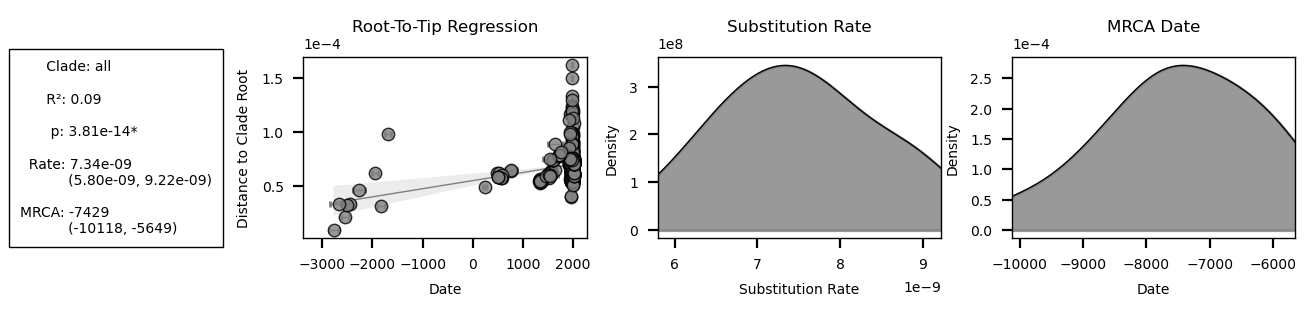

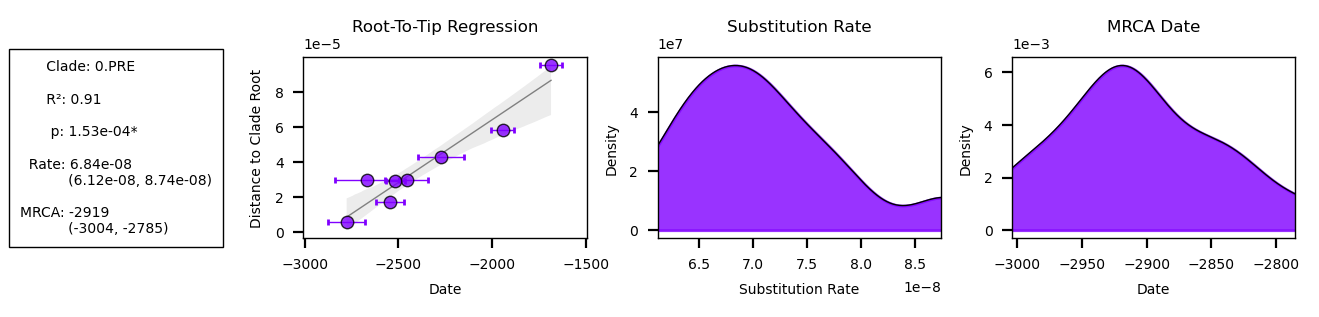

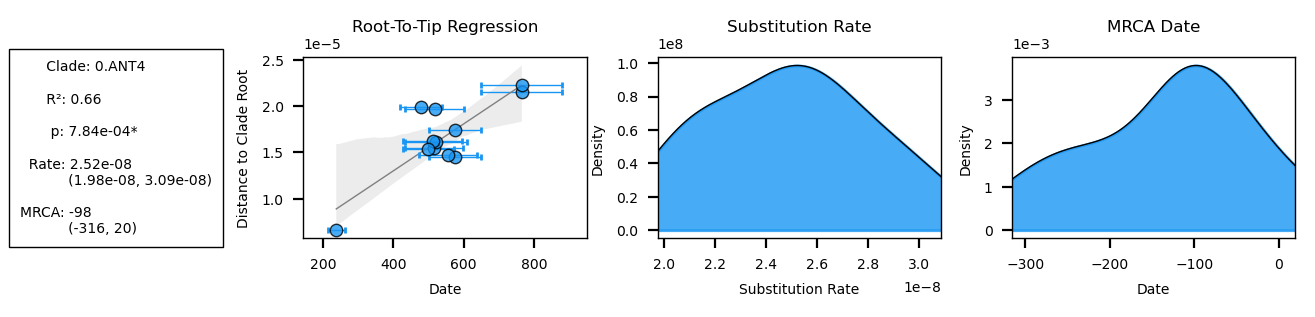

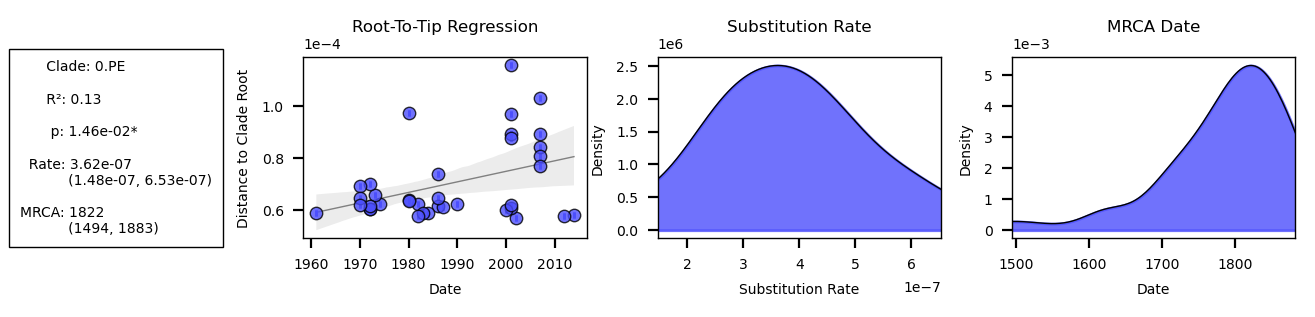

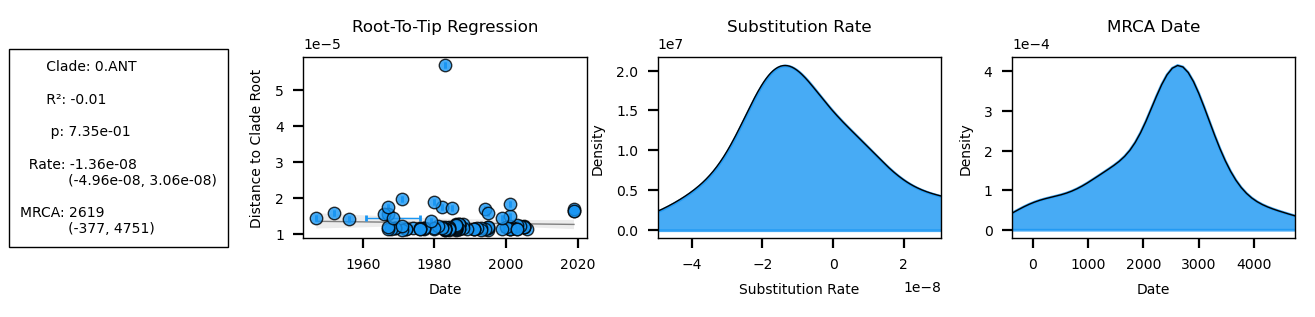

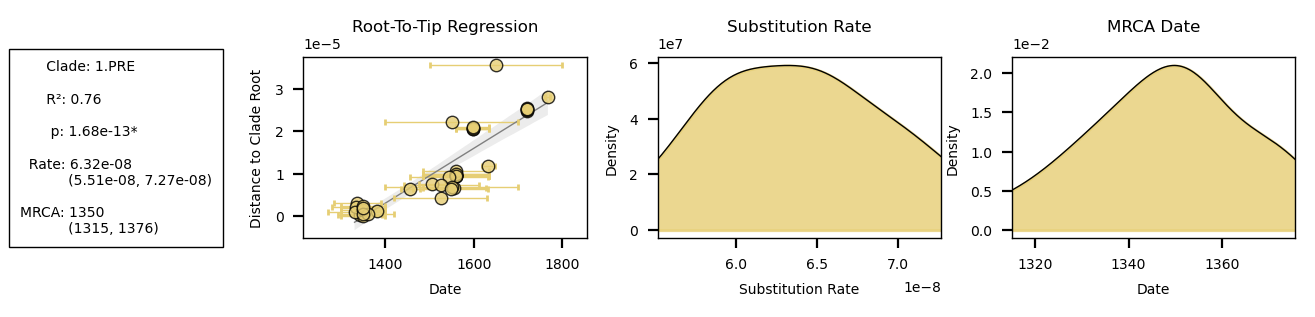

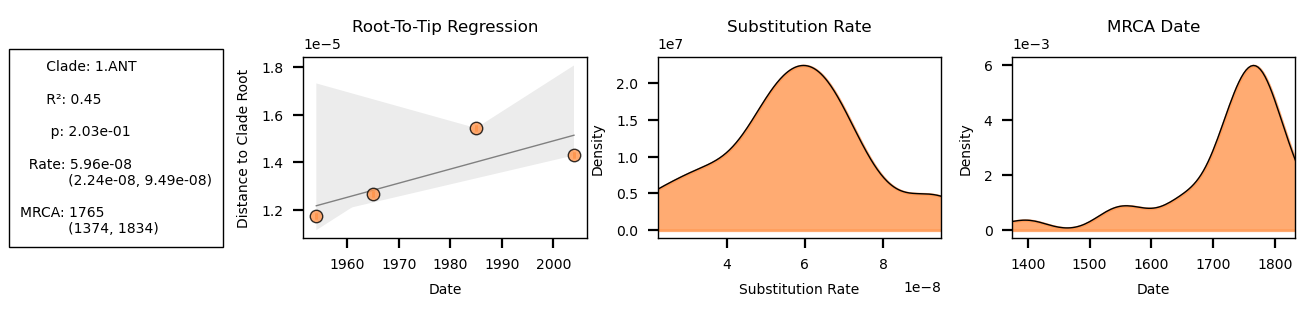

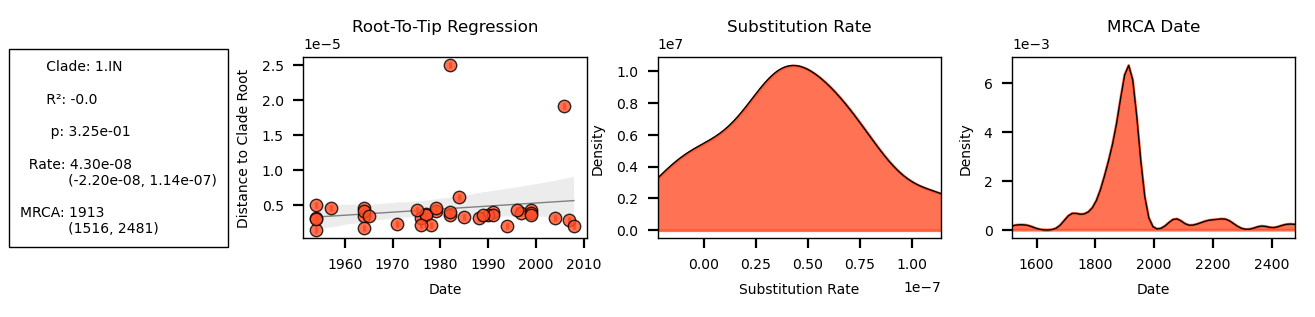

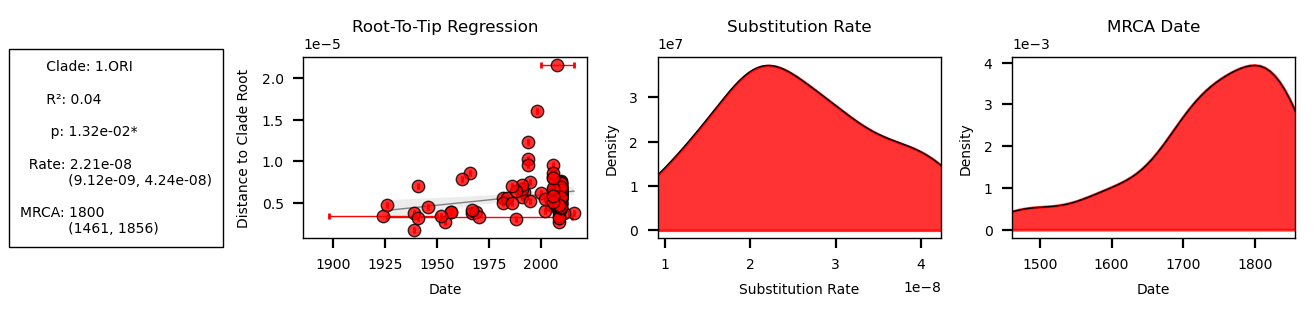

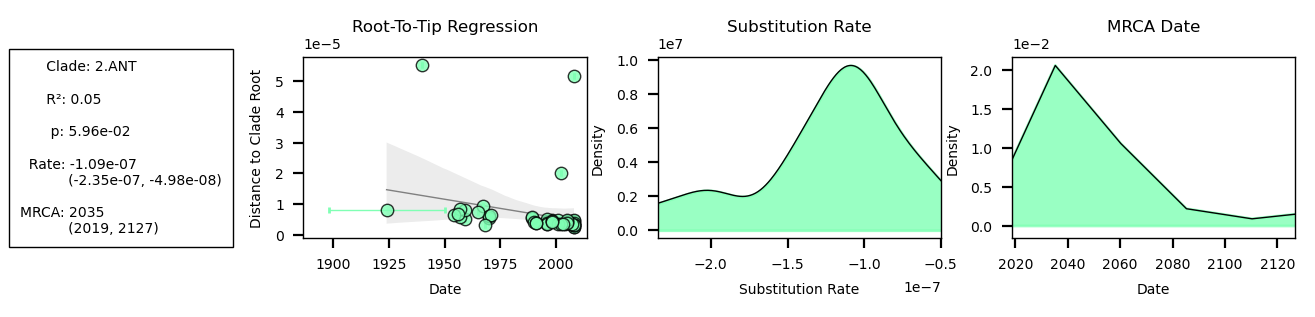

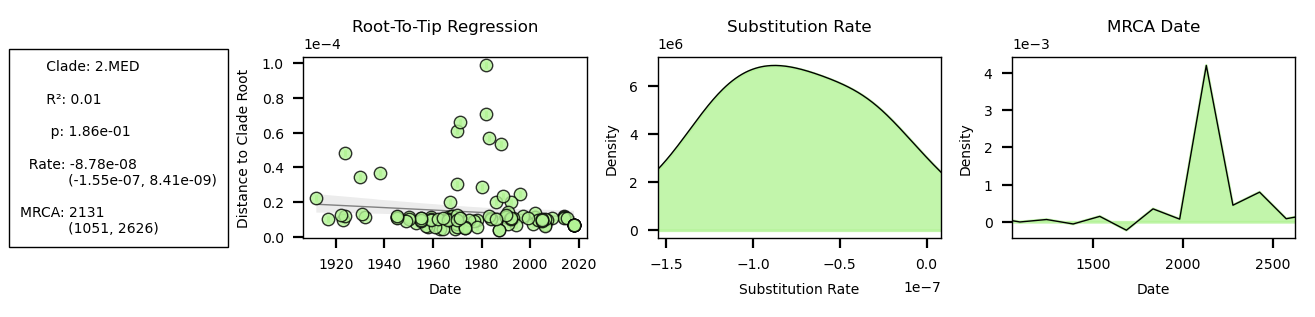

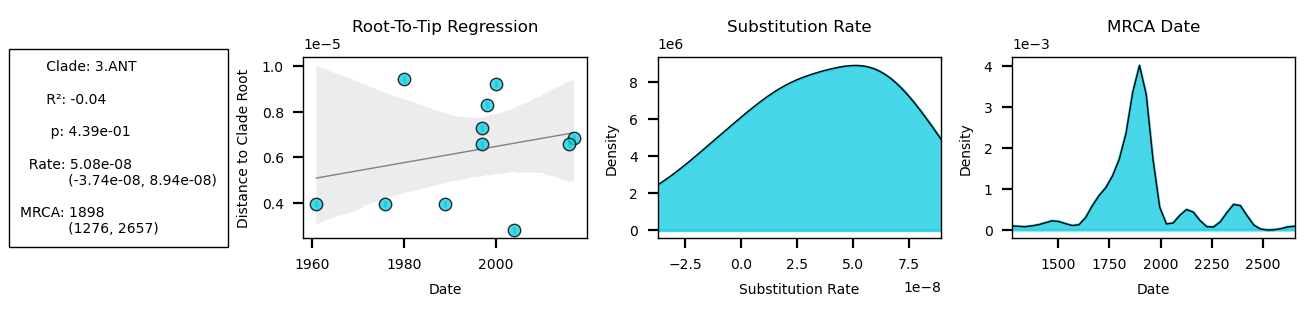

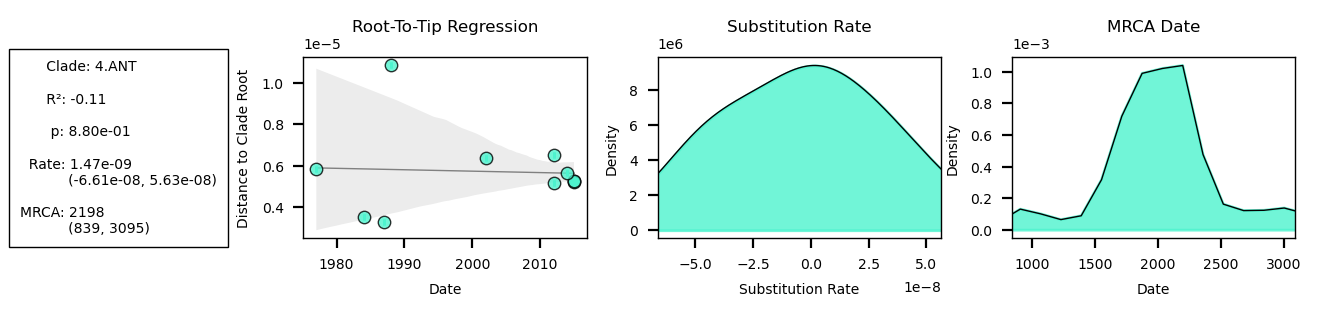

In [10]:
np.random.seed(5435455)
NBOOTS = 100

bootstrap_mega_dict = {}

import sys, importlib
importlib.reload(sys.modules['functions'])
from functions import linregress_bootstrap

# ALL
df = copy.deepcopy(metadata_df[(metadata_df["date_mean"] != NO_DATA_CHAR)])
label = "all"
print("Branch:", label)
color = "grey"
x = list(float(n) for n in df["date_mean"])
y = list(df["root_rtt_dist"])
xerr=list(df["date_err"])

bootstraps = linregress_bootstrap(x=x,y=y,xerr=xerr,nboots=NBOOTS, plot=True, color=color, label=label)
bootstrap_mega_dict["all"] = bootstraps

out_path = os.path.join(out_dir, "rtt_all".format(label))
plt.savefig(out_path + ".png", bbox_inches="tight")
plt.savefig(out_path + ".svg", bbox_inches="tight")

for label in BRANCH_LIST:
    #if label != "1.ORI": continue
    print("Branch:", label)
    df = copy.copy(metadata_df[metadata_df["branch_minor"].isin(BRANCH_LIST[label])])
    color = df["branch_major_color"][0]
    x = list(df["date_mean"])
    y = list(df["clade_rtt_dist"])
    xerr=list(df["date_err"])

    bootstraps = linregress_bootstrap(x=x,y=y,xerr=xerr,nboots=NBOOTS, plot=True, color=color, label=label)
    bootstrap_mega_dict[label] = bootstraps
    out_path = os.path.join(out_dir, "rtt_{}".format(label))
    print(out_path)
    plt.savefig(out_path + ".png", bbox_inches="tight")
    plt.savefig(out_path + ".svg", bbox_inches="tight")


## Extract Temporal Constraints

In [11]:
out_path_constraints = os.path.join(out_dir, "temporal_constraints.txt")
with open(out_path_constraints, "w") as outfile:
    for label in BRANCH_LIST:
        if label not in bootstrap_mega_dict: continue
        #if label != "1.ORI": continue
        df = copy.copy(metadata_df[metadata_df["branch_minor"].isin(BRANCH_LIST[label])])
        tips = list(df.index)

        clade_bootstraps = bootstrap_mega_dict[label]
        p_value = clade_bootstraps["p_value"]
        if p_value >= ALPHA or label == "0.PE": continue
        print("Branch:", label)
        mrca_ci = clade_bootstraps["x_intercept_ci"]
        mrca_ci_bp = ["-" + str(CURRENT_YEAR - d) for d in mrca_ci]

        # LSD mrca constraint format mrca(A,B,C) b(1998.21,2000.5)
        print(mrca_ci)
        outfile.write("mrca({}) b({})\n".format(",".join(tips), ",".join(mrca_ci_bp)))

Branch: 0.PRE
[-3003.95481462 -2785.15560082]
Branch: 0.ANT4
[-315.97433758   19.9084103 ]
Branch: 1.PRE
[1315.07447792 1375.7081516 ]
Branch: 1.ORI
[1461.21609493 1856.03959081]


## Clades Regression Multi Plot

Branch: 0.PRE
Branch: 0.ANT4
Branch: 0.PE
Branch: 0.ANT
Branch: 1.PRE
Branch: 1.ANT
Branch: 1.IN
Branch: 1.ORI
Branch: 2.ANT
Branch: 2.MED
Branch: 3.ANT
Branch: 4.ANT


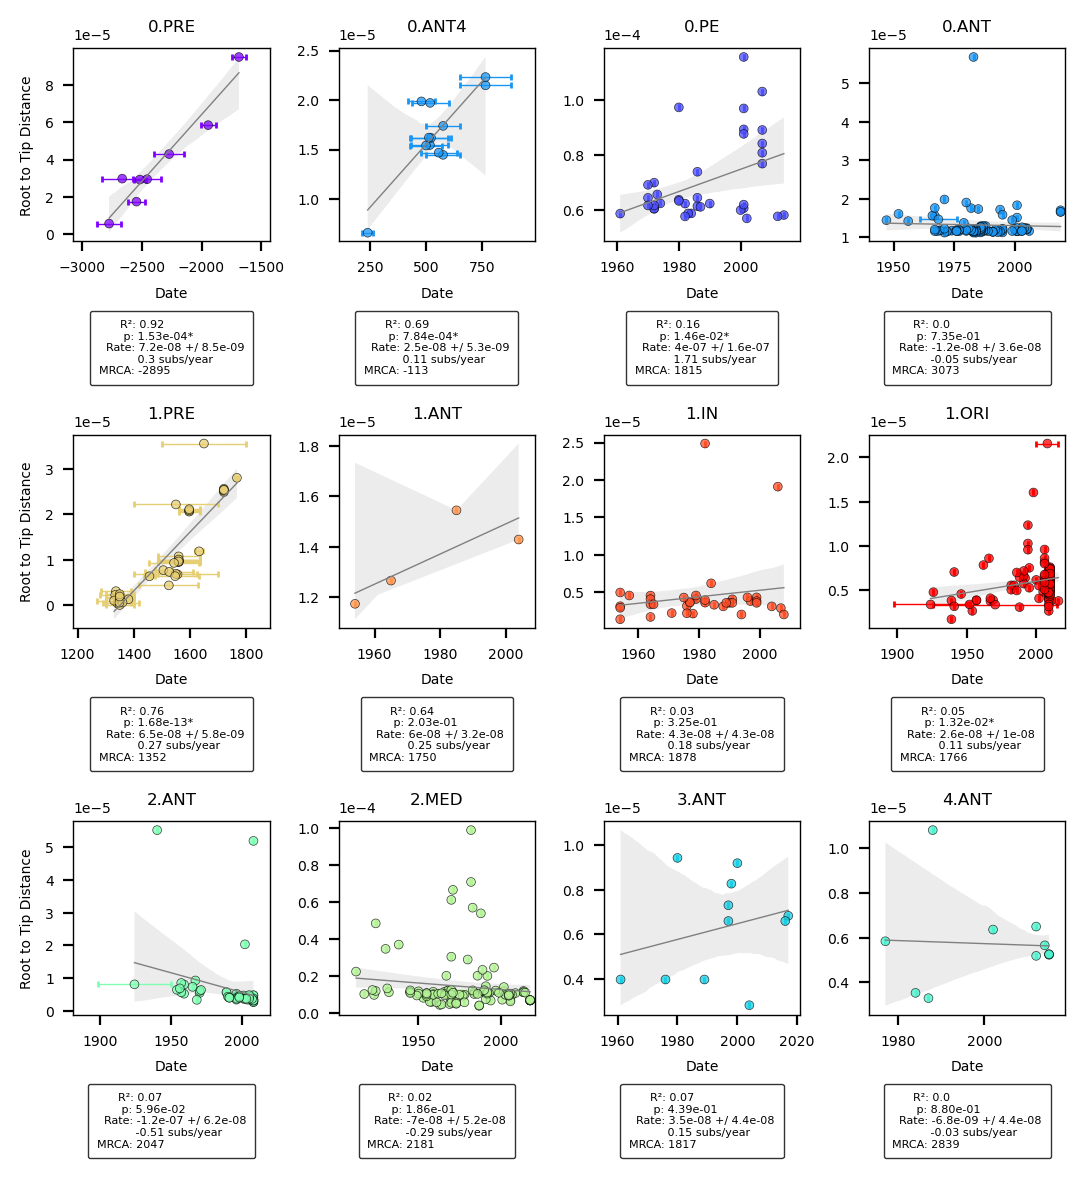

In [12]:
# ---------------------------------------
# PLOT SETUP
TARGET_RES = [1280, 1280]
DPI=200
FIGSIZE=[TARGET_RES[0] / DPI, TARGET_RES[1] / DPI]
FONTSIZE=5
plt.rc('font', size=FONTSIZE)

reg_x = "date_mean"
reg_y = "clade_rtt_dist"
reg_err = "date_err"

nrow=3
ncol=4

fig, axes = plt.subplots(nrow,ncol,figsize=FIGSIZE, dpi=DPI)
fig.subplots_adjust(wspace=0.35, hspace=1)

i_row = 0
i_col = 0

for label in BRANCH_LIST:
    #if label != "1.PRE": continue
    print("Branch:", label)
    
    # ----------------------------------------
    # Setup axis
    ax = axes[i_row][i_col]

    df = copy.copy(metadata_df[metadata_df["branch_minor"].isin(BRANCH_LIST[label])])
    x = list(df[reg_x])
    y = list(df[reg_y])
    # If no records for this branch, continue
    if len(df) < 2: 
        # Update axis
        if i_col == ncol - 1:
            i_col = 0
            i_row += 1
        else:
            i_col += 1        
        continue
    
    # -----------------------
    # Regression
    #slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x,y)
    linear_reg = scipy.stats.linregress(x,y)
    r_value = linear_reg.rvalue
    slope = linear_reg.slope
    intercept = linear_reg.intercept
    p_value = linear_reg.pvalue
    std_err = linear_reg.stderr
    
    r2 = r_value**2 
    y_intercept = CURRENT_YEAR - (0 - intercept)/slope
    p_sig = ""
    if p_value < ALPHA:
        p_sig = "*"
        
    sub_per_year = SEQ_LEN * slope
    year_per_sub = 1 / sub_per_year    
    y_intercept_calendar = CURRENT_YEAR - y_intercept     

    sns.regplot(
        ax=ax,
        data=df, 
        x=list(df[reg_x]), 
        y=list(df[reg_y]), 
        ci=95,
        scatter_kws={"s": 0},
        line_kws={"linewidth" : 0.5},
        color="grey",
        #color=df["branch_major_color"][0],
        label=(
        "      R²: {}".format(round(r2,2))
        + "\n       p: {:.2e}{}".format(p_value, p_sig)
        + "\n  Rate: {:.2} +/ {:.2}".format(slope, std_err)  
        + "\n           {} subs/year".format(round(sub_per_year, 2))
        + "\nMRCA: {}".format(round(y_intercept_calendar))                
        )
    )

    ax.errorbar(
        data=df, 
        x=x, 
        y=y, 
        xerr=list(df[reg_err]),         
        yerr=None,
        ls='none',
        c = df["branch_major_color"][0],  
        capsize=1,
        label=None,
        zorder=1,
        lw=0.5,
        )  
    
    sns.scatterplot(
        ax=ax,
        data=df, 
        x=x, 
        y=y,   
        s=10,
        c = df["branch_major_color"], 
        ec = "black",
        alpha=0.75,
        zorder=2,
    )
    
    # Set xlimits
    xlim = ax.get_xlim()
    x_buff = round((xlim[1] - xlim[0]) * 0.1,1)
    new_xlim = [xlim[0]-x_buff, xlim[1]+x_buff]
    if new_xlim[1] > CURRENT_YEAR:
        new_xlim = [new_xlim[0], CURRENT_YEAR]
    ax.set_xlim(new_xlim)

    # Format and position legend
    legend = ax.legend(
        borderpad=0.8, 
        handletextpad=-2, 
        edgecolor="black", 
        bbox_to_anchor=(0.5, -0.55), 
        loc='center',
        fontsize=FONTSIZE * 0.80,
    )
    frame = legend.get_frame().set_linewidth(0.5)
        
    # Format axis
    ax.set_title(label)

    if i_col == 0:
        ax.set_ylabel("Root to Tip Distance")
    else:
        ax.set_ylabel("")
    ax.set_xlabel("Date")    
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0,0))    
    
    for spine in ax.spines:
        ax.spines[spine].set_linewidth(0.5)    
            

    # Update axis
    if i_col == ncol - 1:
        i_col = 0
        i_row += 1
    else:
        i_col += 1
        
    
out_path = os.path.join(out_dir, "rtt_clades")
plt.savefig(out_path + ".png", bbox_inches="tight")
plt.savefig(out_path + ".svg", bbox_inches="tight")

---
# 3. IBD (Isolation By Distance)

## Calculate

In [13]:
"""ibd_dict = {}

for label in BRANCH_LIST:
    print("Label:", label)    
    ibd_dict[label] = {"geo_dist" : [], "genetic_dist" : []}
    df = metadata_df[metadata_df["branch_minor"].isin(BRANCH_LIST[label])]   
    
    i_compare = 0
    i = 0
    for sample1 in df.index:
        geom1 = df["geometry"][sample1]
        coord1 = (geom1.y, geom1.x)  
        for sample2 in df.index[i_compare:]:
            if sample1 == sample2: continue
            geom2 = df["geometry"][sample2]
            coord2 = (geom2.y, geom2.x)
            geo_dist = geopy.distance.great_circle(coord1, coord2).km
            genetic_dist = divtree.distance(sample1, sample2)

            ibd_dict[label]["geo_dist"].append(geo_dist)
            ibd_dict[label]["genetic_dist"].append(genetic_dist)
        i_compare += 1"""

'ibd_dict = {}\n\nfor label in BRANCH_LIST:\n    print("Label:", label)    \n    ibd_dict[label] = {"geo_dist" : [], "genetic_dist" : []}\n    df = metadata_df[metadata_df["branch_minor"].isin(BRANCH_LIST[label])]   \n    \n    i_compare = 0\n    i = 0\n    for sample1 in df.index:\n        geom1 = df["geometry"][sample1]\n        coord1 = (geom1.y, geom1.x)  \n        for sample2 in df.index[i_compare:]:\n            if sample1 == sample2: continue\n            geom2 = df["geometry"][sample2]\n            coord2 = (geom2.y, geom2.x)\n            geo_dist = geopy.distance.great_circle(coord1, coord2).km\n            genetic_dist = divtree.distance(sample1, sample2)\n\n            ibd_dict[label]["geo_dist"].append(geo_dist)\n            ibd_dict[label]["genetic_dist"].append(genetic_dist)\n        i_compare += 1'

# All

In [14]:
"""# ---------------------------------------
# PLOT SETUP
TARGET_RES = [480, 480]
DPI=200
FIGSIZE=[TARGET_RES[0] / DPI, TARGET_RES[1] / DPI]
FONTSIZE=5
plt.rc('font', size=FONTSIZE)

geo_dist_all = []
genetic_dist_all = []

fig, ax = plt.subplots(1,figsize=FIGSIZE, dpi=DPI)

for branch in ibd_dict:
    geo_dist_all = geo_dist_all + ibd_dict[branch]["geo_dist"]
    genetic_dist_all = genetic_dist_all + ibd_dict[branch]["genetic_dist"]

sns.regplot(
    ax=ax,
    x=geo_dist_all,
    y=genetic_dist_all,
    ci=95,
    scatter_kws={"s": 0},
    color="grey",
    line_kws={"linewidth":0.5},
    label=(
    "   R²: {}".format(round(r2,2))
    + "\n     p: {:.2e}{}".format(p_value, p_sig)             
    )
)
    
sns.scatterplot(
    ax=ax,
    x=geo_dist_all,
    y=genetic_dist_all,
    s=1,
    ec = "white", 
    color="black",
    alpha=0.75,
    zorder=2,
)

# Format and position legend
legend = ax.legend(
    borderpad=0.8, 
    handletextpad=-2, 
    edgecolor="black", 
    #bbox_to_anchor=(0.5, -0.30), 
    #loc='center',
    fontsize=FONTSIZE,
)
frame = legend.get_frame().set_linewidth(0.5)

ax.set_ylabel("Genetic Distance (subs / site)")
ax.set_xlabel("Great Circle Distance (km)")
ax.ticklabel_format(axis="y", style="sci", scilimits=(0,0))    

out_path = os.path.join(out_dir, "ibd_all")
plt.savefig(out_path + ".png", bbox_inches="tight")
plt.savefig(out_path + ".svg", bbox_inches="tight")"""

'# ---------------------------------------\n# PLOT SETUP\nTARGET_RES = [480, 480]\nDPI=200\nFIGSIZE=[TARGET_RES[0] / DPI, TARGET_RES[1] / DPI]\nFONTSIZE=5\nplt.rc(\'font\', size=FONTSIZE)\n\ngeo_dist_all = []\ngenetic_dist_all = []\n\nfig, ax = plt.subplots(1,figsize=FIGSIZE, dpi=DPI)\n\nfor branch in ibd_dict:\n    geo_dist_all = geo_dist_all + ibd_dict[branch]["geo_dist"]\n    genetic_dist_all = genetic_dist_all + ibd_dict[branch]["genetic_dist"]\n\nsns.regplot(\n    ax=ax,\n    x=geo_dist_all,\n    y=genetic_dist_all,\n    ci=95,\n    scatter_kws={"s": 0},\n    color="grey",\n    line_kws={"linewidth":0.5},\n    label=(\n    "   R²: {}".format(round(r2,2))\n    + "\n     p: {:.2e}{}".format(p_value, p_sig)             \n    )\n)\n    \nsns.scatterplot(\n    ax=ax,\n    x=geo_dist_all,\n    y=genetic_dist_all,\n    s=1,\n    ec = "white", \n    color="black",\n    alpha=0.75,\n    zorder=2,\n)\n\n# Format and position legend\nlegend = ax.legend(\n    borderpad=0.8, \n    handletextpa

## Clades

In [15]:
"""# ---------------------------------------
# PLOT SETUP
TARGET_RES = [1280, 1280]
DPI=200
FIGSIZE=[TARGET_RES[0] / DPI, TARGET_RES[1] / DPI]
FONTSIZE=5
plt.rc('font', size=FONTSIZE)

nrow=3
ncol=4

fig, axes = plt.subplots(nrow,ncol,figsize=FIGSIZE, dpi=DPI)
fig.subplots_adjust(wspace=0.35, hspace=0.75)


i_row = 0
i_col = 0

for label in BRANCH_LIST:
    # ----------------------------------------
    # Setup axis
    ax = axes[i_row][i_col]

    df = metadata_gdf[metadata_gdf["branch_minor"].isin(BRANCH_LIST[label])]  
    
    if len(df) < 3:
        # Update axis
        if i_col == ncol - 1:
            i_col = 0
            i_row += 1
        else:
            i_col += 1        
        continue
    
    # -----------------------
    # Regression
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(ibd_dict[label]["geo_dist"],ibd_dict[label]["genetic_dist"])
    r2 = r_value * r_value    
    y_intercept = CURRENT_YEAR - (0 - intercept)/slope
    p_sig = "" 
    if p_value < ALPHA:
        p_sig = "*"
        
    mut_per_year = SEQ_LEN * slope
    year_per_mut = 1 / mut_per_year
    
    reg_dict = {
        "slope": slope,
        "x_intercept" : intercept,
        "y_intercept" : y_intercept,
        "p_value" : p_value,
        "p_sig" : p_sig,
        "year_per_mut" : year_per_mut
    }
    
    sns.regplot(
        ax=ax,
        x=ibd_dict[label]["geo_dist"],
        y=ibd_dict[label]["genetic_dist"],
        ci=95,
        scatter_kws={"s": 0},
        color="grey",
        line_kws={"linewidth":0.5},
        label=(
        "   R²: {}".format(round(r2,2))
        + "\n     p: {:.2e}{}".format(p_value, p_sig)             
        )
    )

    sns.scatterplot(
        ax=ax,
        x=ibd_dict[label]["geo_dist"],
        y=ibd_dict[label]["genetic_dist"],
        s=10,
        ec = "black",
        color = df["branch_major_color"][0],         
        alpha=0.75,
        zorder=2,
    )
     
    # Format and position legend
    legend = ax.legend(
        borderpad=0.8, 
        handletextpad=-2, 
        edgecolor="black", 
        bbox_to_anchor=(0.5, -0.40), 
        loc='center',
        fontsize=FONTSIZE * 0.80,
    )
    frame = legend.get_frame().set_linewidth(0.5)        
    
    # Set xlimits
    xlim = ax.get_xlim()
    if xlim[1] > 20000:
        xbuff = 5000   
    elif xlim[1] > 2000:
        xbuff = 500
    elif xlim[1] > 200:
        xbuff = 50
    ax.set_xlim(0-xbuff, xlim[1] + xbuff)
        
    # Format axis
    ax.set_title(label)

    if i_col == 0:
        ax.set_ylabel("Genetic Distance (subs / site)")
    else:
        ax.set_ylabel("")
    ax.set_xlabel("Great Circle Distance (km)")
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0,0))    
    
    for spine in ax.spines:
        ax.spines[spine].set_linewidth(0.5)    
            

    # Update axis
    if i_col == ncol - 1:
        i_col = 0
        i_row += 1
    else:
        i_col += 1

    
out_path = os.path.join(out_dir, "ibd_clades")
plt.savefig(out_path + ".png", bbox_inches="tight")
plt.savefig(out_path + ".svg", bbox_inches="tight")"""

'# ---------------------------------------\n# PLOT SETUP\nTARGET_RES = [1280, 1280]\nDPI=200\nFIGSIZE=[TARGET_RES[0] / DPI, TARGET_RES[1] / DPI]\nFONTSIZE=5\nplt.rc(\'font\', size=FONTSIZE)\n\nnrow=3\nncol=4\n\nfig, axes = plt.subplots(nrow,ncol,figsize=FIGSIZE, dpi=DPI)\nfig.subplots_adjust(wspace=0.35, hspace=0.75)\n\n\ni_row = 0\ni_col = 0\n\nfor label in BRANCH_LIST:\n    # ----------------------------------------\n    # Setup axis\n    ax = axes[i_row][i_col]\n\n    df = metadata_gdf[metadata_gdf["branch_minor"].isin(BRANCH_LIST[label])]  \n    \n    if len(df) < 3:\n        # Update axis\n        if i_col == ncol - 1:\n            i_col = 0\n            i_row += 1\n        else:\n            i_col += 1        \n        continue\n    \n    # -----------------------\n    # Regression\n    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(ibd_dict[label]["geo_dist"],ibd_dict[label]["genetic_dist"])\n    r2 = r_value * r_value    \n    y_intercept = CURRENT_YEAR - 